In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import .fit (Garmin) handling
from fitparse import FitFile

import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt 
#import ipynb.fit_functions as ffun
%run fit_functions.ipynb

#Signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

#Itertools
import itertools

#Time
import time


import json

#KERAS AND TENSORFLOW
import tensorflow as tf
tf.random.set_seed(1234)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
#from keras.preprocessing import timeseries_dataset_from_array
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam
import keras
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

#TIMESERIES
from numpy.lib.stride_tricks import sliding_window_view

#GARBAGE COLLECTOR
import gc

#os.environ["CUDA_VISIBLE_DEVICES"] = '6'
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#for physical_device in physical_devices:
#    tf.config.experimental.set_memory_growth(physical_device, True)
#config.gpu_options.per_process_gpu_memory_fraction = 1
#tf.compat.v1.disable_eager_execution()


tensorflow-macos 2.9.2
tensorflow-

In [2]:
#path_to_data = '/home/stud/jakobsv/bhome/T2'
path_to_data = '/Users/2924467/Documents/PhD-main/Code/T2'

In [3]:
participant_files = ([f for f in listdir(path_to_data) if isfile(join(path_to_data, f)) 
                      and not f.startswith('.')]) #Include this to exclude .ds_store file
print(participant_files) #This list can be used to determine which participant we are looking at as well

['50388.FIT', '50808.FIT', '50766.FIT', '50835.FIT', '50821.FIT', '50162.FIT', '50764.FIT', '50599.FIT', '50953.FIT', '50364.FIT', '50229100.FIT', '50300.FIT', '50314.FIT', '50499.FIT', '50880.FIT', '50465.FIT', '50897.FIT', '50539.FIT', '50712.FIT', '50048.FIT', '50305.FIT', '50649.FIT', '50846.FIT', '50503.FIT', '50927.FIT', '50714.FIT', '50847.FIT', '50338.FIT', '50863.FIT', '50493.FIT', '50257.FIT', '50087.FIT', '50497.FIT', '50640.FIT', '50697.FIT', '50286.FIT', '50279.FIT', '50899.FIT', '50342.FIT', '50229093.FIT', '50356.FIT', '50627.FIT', '50355.FIT', '50817.FIT', '50152.FIT', '50998.FIT', '50542.FIT', '50556.FIT', '50972.FIT', '50635.FIT', '50153.FIT', '50409.FIT', '50810.FIT', '50229108.FIT', '50226.FIT', '50965.FIT', '50805.FIT', '50187.FIT', '50434.FIT']


In [4]:

def speed_corr(speed):
    return speed if isinstance(speed, float) else 0 #To make sure the speed is float. 

def read_record(rec): #Function to read message-type "record" from .fit files. This is the most interesting
    global curr_stop
    global hrv_timestamp #Define global variable for timestamp to use for the HRV-messages, since these messages lack timestamps.
    hrv_timestamp = rec.get_value('timestamp') 
    if curr_stop == 1 and speed_corr(rec.get_value('speed')) > 2: #If we are at a stop, but have started moving again...
        curr_stop = 0 #... then we are not at a stop. 
    
    return (rec.get_value('timestamp'), 1, curr_lap, curr_stop, #Second column is 'type'
            rec.get_value('speed'), rec.get_value('enhanced_speed'),
            rec.get_value('distance'), rec.get_value('heart_rate'), 
            rec.get_value('accumulated_power'), rec.get_value('power'), 
            rec.get_value('position_lat'), rec.get_value('position_long'), 
            rec.get_value('altitude'), rec.get_value('enhanced_altitude'), 
            rec.get_value('cadence'), rec.get_value('factional_cadence'), 
            rec.get_value('left_right_balance'), rec.get_value('left_torque_effectiveness'), 
            rec.get_value('right_torque_effectiveness'), rec.get_value('left_pedal_smoothness'), 
            rec.get_value('right_pedal_smoothness'), rec.get_value('temperature'), np.NaN) #Last column is HRV

def read_lap(rec): #Function to read message-type "lap" from .fit files. 
    global curr_lap #Variable to show which lap we are at
    global curr_stop #Variable to show if we are at a stop or not
    curr_lap += 1
    curr_stop = 1
    return (rec.get_value('timestamp'), 2, curr_lap, curr_stop, np.NaN, np.NaN, rec.get_value('total_distance'), np.NaN, np.NaN, 
            np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, 
            np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN)

def read_hrv(rec): 
    return (hrv_timestamp, 3, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, 
            np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, 
            np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, list(filter(None,rec.get_value('time')))) #rec.get_value('time'))

fitgen_cols = ['timestamp', 'type', 'lap', 'stop', 'speed', 'enhanced_speed', 'distance', 'heart_rate', 
               'accumulated_power', 'power', 'position_lat', 'position_long', 
               'altitude', 'enhanced_altitude', 'cadence', 'factional_cadence', 
               'left_right_balnce', 'left_torque_effectiveness', 'right_torque_effectiveness', 
               'left_pedal_smoothness', 'right_pedal_smoothness', 'temperature', 'hrv'] #Column names for dataframe

#initialize 'begin' and 'end' as empty timestamps
start = pd.Timestamp(2020, 1, 1, 12) #Unreasonably high starting point to fit with if-sentence later
end = pd.Timestamp(2016, 1, 1, 12) #Unreasonably low ending point to fit with if-sentence later

all_dfs = [] #List of all dataframes for all persons
all_stops = [] #List of dataframe for all stop messages for all persons
all_hrv = [] #List of hrv data for all persons

for participant_file in participant_files: #For every person
    
    
    fitfile = FitFile(path_to_data + '/'+participant_file) 
    
    #print(participant_file, 'start')
    
    curr_lap = 0 #Initialize current lap to zero
    curr_stop = 0 #Initialize current stop to zero
    hrv_timestamp = start #Initialize hrv_timestamp to start timestamp
    
    
    fitgen = (read_record(rec) if rec.name=='record' else (read_lap(rec) if rec.name == 'lap' else read_hrv(rec))
          for rec in fitfile.get_messages(['record', 'lap', 'hrv'])) #Extracts the data and saves it in 'fitgen' based on the type of message (record/lap/hrv).
    
    

     
         
    
    #print(participant_file, 'read')
    
    part_df = pd.DataFrame(fitgen, columns=fitgen_cols) #Converts the data of the current participant to a pandas dataframe.
    all_dfs.append(part_df[part_df['type']==1].set_index('timestamp')) #Appends part_df to all_df. Sets the index column to the timestamp column, this is based on the value of 'type' (1-record, 2-stop, 3-hrv) in the message. 
    all_stops.append(part_df[part_df['type']==2].set_index('timestamp')) #Appends part_df to all_stops. Sets the index column to the timestamp column, this is based on the value of 'type' (1-record, 2-stop, 3-hrv) in the message.
    all_hrv.append(part_df[part_df['type']==3].set_index('timestamp')) #Appends part_df to all_hrv. Sets the index column to the timestamp column, this is based on the value of 'type' (1-record, 2-stop, 3-hrv) in the message.
    
    
    #if all_dfs[-1].index[0]<start: start = all_dfs[-1].index[0] #If the variable 'start' is bigger than the first timestamp, redefine 'start'. Calculated for the last participant (index -1)
    #if all_dfs[-1].index[-1]>end: end = all_dfs[-1].index[-1] #If the variable 'end' is smaller than the last timestamp, redefine 'end'. Calculated for the last participant (index -1)
    #
    #if all_hrv[-1].index[0]<start: start = all_hrv[-1].index[0] #If the variable 'start' is bigger than the first timestamp, redefine 'start'. Calculated for the last participant (index -1)
    #if all_hrv[-1].index[-1]>end: end = all_hrv[-1].index[-1] #If the variable 'end' is smaller than the last timestamp, redefine 'end'. Calculated for the last participant (index -1)
    
    start = all_dfs[-1].index[0]
    end = all_dfs[-1].index[-1]
    
    
    #print(participant_file, 'converted')

    new_index = pd.date_range(start=start, end=end, freq='s') #Create timeseries dataframe with one second between each new row.
    all_dfs[-1] = all_dfs[-1].reindex(new_index)
#new_index = pd.date_range(start=start, end=end, freq='s') #Create timeseries dataframe with one second between each new row.
#for i in range(len(all_dfs)): #regular for loop without counter doesn't work
    #all_dfs[i] = all_dfs[i].reindex(new_index) #Places NA/NaN in locations having no value in the previous dataframe
    
    

    
new_hrv = [] #Initialize new list of hrv-dataframes (this way we dont have to run the entire code for every tweak)
master_dfs = [] #Initialize master dataframe
for i in range(len(all_hrv)):
    new_hrv.append(all_hrv[i]['hrv']) #.replace([np.NaN, np.NaN, np.NaN, np.NaN, np.NaN], np.NaN)) #Remove all hrv-lists with only NaN-values
    new_hrv[i] = all_hrv[i][~all_hrv[i].index.duplicated(keep='first')] #Only want one hrv-list for each timestamp. Assume the first instance is adequate.
    master_dfs.append(all_dfs[i].copy()) #Create new master dataframe
    master_dfs[i]['hrv']=new_hrv[i]['hrv'] #Add hrv-data to master dataframe

#Create a dictionary for master_dfs, so that the dataframes can be accessed by string as well
master_dict = {}
for i in range(len(master_dfs)):
    master_dict[participant_files[i]] = master_dfs[i]

#Dictionary for all_stops
stops_dict = {}
for i in range(len(all_stops)):
    stops_dict[participant_files[i]] = all_stops[i]


In [5]:

#PREPARE DATA FOR RECURRENT NEURAL NETWORK

def prepare_data(num_train, num_val, sampling_rate, sequence_length, batch_size, pers):
    
    num_train_samples = int(num_train*len(pers))
    num_val_samples = int(num_val*len(pers))
    num_test_samples = len(pers) - num_train_samples - num_val_samples

    train_dataset = TimeseriesGenerator(
        data = pers,
        targets = pers,
        sampling_rate=sampling_rate,
        length=sequence_length,
        shuffle=False,
        batch_size=batch_size,
        start_index=0,
        end_index=num_train_samples)

    val_dataset = TimeseriesGenerator(
        data = pers,
        targets = pers,
        sampling_rate=sampling_rate,
        length=sequence_length,
        shuffle=False,
        batch_size=batch_size,
        start_index=num_train_samples,
        end_index = num_train_samples+num_val_samples)

   

    test_dataset = TimeseriesGenerator(
            data = pers,
            targets = pers,
            sampling_rate=sampling_rate,
            length=sequence_length,
            shuffle=False,
            batch_size=batch_size,
            start_index=num_train_samples+num_val_samples)
        
    return train_dataset, val_dataset, test_dataset

        #for samples, targets in test_persset:
        #print(samples)
        #print(targets)


def prepare_prediction(pers, sequence_length, sampling_rate, batch_size):
    pred = TimeseriesGenerator(
        data = pers,
        targets = pers,
        sampling_rate=sampling_rate,
        length=sequence_length,
        shuffle=False,
        batch_size=batch_size)
    
    return pred


In [6]:
def create_dataset(dataset, sequence_length,sampling_rate,n_forecast):
    dataX, dataY = [], []
    for i in range(len(dataset)-sequence_length*sampling_rate-n_forecast+1):
        a = dataset[i:(i+sequence_length*sampling_rate):sampling_rate]
        dataX.append(a)
        dataY.append(dataset[i + sequence_length*sampling_rate-(sampling_rate-1):i + sequence_length*sampling_rate+n_forecast-(sampling_rate-1)])
    return np.array(dataX), np.array(dataY)

I think timeseries_dataset_from_array does not work properly in tensorflow 2.3 (which is what gorina6 is). Its seems that in tensorflow 2.3, the function requires the data and target to be of the same length, which does not really make sense.

MAKE HOMEMADE VERSION OF timeseries_dataset_from_array FOR WHEN RUNNING ON GPUs

In [7]:
def homemade_slide(pers,n_forecast):
    out = np.zeros([len(pers)-n_forecast+1,n_forecast])
    for i in range(len(pers)-n_forecast+1):
        slide = pers[i:i+n_forecast]
        out[i] = slide
    return out

def prepare_data2(num_train, num_val, sampling_rate, sequence_length, batch_size, pers, n_forecast):
    
    num_train_samples = int(num_train*len(pers))
    num_val_samples = int(num_val*len(pers))
    num_test_samples = len(pers) - num_train_samples - num_val_samples


    target = homemade_slide(pers,n_forecast)


    train_dataset = timeseries_dataset_from_array(
        data = pers,
        targets = target[(sequence_length-1)*sampling_rate+1:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=False,
        batch_size=batch_size,
        start_index=0,
        end_index=num_train_samples)

    val_dataset = timeseries_dataset_from_array(
        data = pers,
        targets = target[(sequence_length-1)*sampling_rate+1:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=False,
        batch_size=batch_size,
        start_index=num_train_samples,
        end_index = num_train_samples+num_val_samples)

   

    test_dataset = timeseries_dataset_from_array(
            data = pers,
            targets = target[(sequence_length-1)*sampling_rate+1:],
            sampling_rate=sampling_rate,
            sequence_length=sequence_length,
            shuffle=False,
            batch_size=batch_size,
            start_index=num_train_samples+num_val_samples,
            #end_index = int(len(pers)-n_forecast)
            )

        
    return train_dataset, val_dataset, test_dataset

def prepare_prediction2(pers,sampling_rate, sequence_length, batch_size, n_forecast):
    
    target = homemade_slide(pers,n_forecast)
    
    pred = timeseries_dataset_from_array(
        data = pers,
        targets = target[(sequence_length-1)*sampling_rate+1:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    return pred


Expected data and targets to have the same number of time steps (axis 0) but got shape(data) = (871,); shape(targets) = (857, 10).')

In [8]:
def interpolate(rr_manual):
    #Interpolate
    x = np.cumsum(rr_manual) #In seconds
    f = interp1d(x, rr_manual*1000, kind='cubic') #In milliseconds

    fs = 4.0 #Sample frequency
    steps = 1 / fs

    # now we can sample from interpolation function
    xx = np.arange(x[0], np.max(x), steps)
    rr_interpolated = f(xx)
    return rr_interpolated

def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rri, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    return vlf, lf, hf, total_power

def hrv_metric(rr):
    rr = np.array([rr])
    rr = rr.reshape(-1)

    # RMSSD: take the square root of the mean square of the differences
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr*1000)))) #Need the data to be in milliseconds, therefore rr*1000

    # SDNN
    sdnn = np.std(rr*1000) #Need the data to be in milliseconds, therefore rr*1000

    try:
        rr_interpolated = interpolate(rr)

        vlf, lf, hf, total_power = frequency_domain(rr_interpolated,4)
    except:
        vlf, lf, hf, total_power = 'error','error','error','error'
        
    return rmssd, sdnn, vlf, lf, hf, total_power
    #return rmssd, sdnn

def cubic_spline(rr,start_hole,pred_length):

    time_rr = np.cumsum(rr)
    
    x1 = time_rr[start_hole-2]
    x2 = time_rr[start_hole-1]
    x3 = time_rr[start_hole+pred_length]
    x4 = time_rr[start_hole+pred_length+1]
    
    y1 = rr[start_hole-2]
    y2 = rr[start_hole-1]
    y3 = rr[start_hole+pred_length]
    y4 = rr[start_hole+pred_length]

    x = np.array([x1,x2,x3,x4])
    f = interp1d(x, [y1,y2,y3,y4], kind='cubic') #In milliseconds

    # now we can sample from interpolation function
    xx = np.linspace(x2, x3,pred_length+2)
    rr_interpolated = f(xx)
    return rr_interpolated

In [9]:
source_data = []
source_data.append(np.array(np.sum(master_dict['50087.FIT']['hrv'].loc['20180609101500':'20180609102000'].values)))
source_data.append(np.array(np.sum(master_dict['50152.FIT']['hrv'].loc['20180609101340':'20180609101630'].values)))
source_data.append(np.array(np.sum(master_dict['50153.FIT']['hrv'].loc['20180609092800':'20180609093230'].values)))
#source_data.append(np.array(np.sum(master_dict['50229093.FIT']['hrv'].loc['20180609100300':'20180609100420'].values)))
source_data.append(np.array(np.sum(master_dict['50229100.FIT']['hrv'].loc['20180609085620':'20180609090220'].values)))
source_data.append(np.array(np.sum(master_dict['50229108.FIT']['hrv'].loc['20180609102220':'20180609102840'].values)))
source_data.append(np.array(np.sum(master_dict['50279.FIT']['hrv'].loc['20180609104345':'20180609104550'].values)))
source_data.append(np.array(np.sum(master_dict['50286.FIT']['hrv'].loc['20180609092945':'20180609093650'].values)))
source_data.append(np.array(np.sum(master_dict['50300.FIT']['hrv'].loc['20180609104000':'20180609104800'].values)))
source_data.append(np.array(np.sum(master_dict['50338.FIT']['hrv'].loc['20180609104000':'20180609104420'].values)))
source_data.append(np.array(np.sum(master_dict['50364.FIT']['hrv'].loc['20180609105100':'20180609105620'].values)))
source_data.append(np.array(np.sum(master_dict['50434.FIT']['hrv'].loc['20180609080920':'20180609081140'].values)))
#source_data.append(np.array(np.sum(master_dict['50493.FIT']['hrv'].loc['20180609100850':'20180609101000'].values)))
source_data.append(np.array(np.sum(master_dict['50503.FIT']['hrv'].loc['20180609082830':'20180609083220'].values)))
source_data.append(np.array(np.sum(master_dict['50539.FIT']['hrv'].loc['20180609095000':'20180609095740'].values)))
source_data.append(np.array(np.sum(master_dict['50635.FIT']['hrv'].loc['20180609082850':'20180609083230'].values)))
source_data.append(np.array(np.sum(master_dict['50764.FIT']['hrv'].loc['20180609101520':'20180609102000'].values)))
source_data.append(np.array(np.sum(master_dict['50805.FIT']['hrv'].loc['20180609093450':'20180609093940'].values)))
source_data.append(np.array(np.sum(master_dict['50808.FIT']['hrv'].loc['20180609085930':'20180609090410'].values)))
source_data.append(np.array(np.sum(master_dict['50817.FIT']['hrv'].loc['20180609085630':'20180609090010'].values)))
source_data.append(np.array(np.sum(master_dict['50821.FIT']['hrv'].loc['20180609083330':'20180609083620'].values)))
source_data.append(np.array(np.sum(master_dict['50835.FIT']['hrv'].loc['20180609082740':'20180609083300'].values)))
source_data.append(np.array(np.sum(master_dict['50846.FIT']['hrv'].loc['20180609092340':'20180609092830'].values)))
source_data.append(np.array(np.sum(master_dict['50899.FIT']['hrv'].loc['20180609085040':'20180609085410'].values)))
source_data.append(np.array(np.sum(master_dict['50965.FIT']['hrv'].loc['20180609082520':'20180609082930'].values)))

In [10]:
phys_path = '/Users/2924467/Documents/PhD-main/Code/Physionet/'
phys_files = ([f for f in listdir(phys_path) if isfile(join(phys_path, f)) 
                      and not f.startswith('.')]) #Include this to exclude .ds_store file
phys_files = np.sort(phys_files)
phys_files

phys_data = []
for part in phys_files:
    res_df = pd.read_csv(phys_path + part,sep=",")
    idx = res_df.loc[res_df['[Params]']=='[HRData]'].index[-1]
    idx+=1
    physionet = res_df.iloc[idx:-1].astype(int).values
    physionet = (physionet.reshape(-1))/1000
    phys_data.append(physionet)

physio_data = []
physio_data.append(phys_data[0][4822:5491]) 
physio_data.append(phys_data[1][3823:4661])
physio_data.append(phys_data[2][3798:4533])
physio_data.append(phys_data[3][2299:2997]) 
physio_data.append(phys_data[4][2634:3320]) 
physio_data.append(phys_data[6][1810:2485]) 
physio_data.append(phys_data[7][4075:4778]) 
physio_data.append(phys_data[8][2222:2886]) 
physio_data.append(phys_data[9][2543:3281]) 
physio_data.append(phys_data[10][2724:3482])
physio_data.append(phys_data[11][2211:2890]) 
physio_data.append(phys_data[12][3918:4671]) 


array(['x001_POLAR.csv', 'x002_POLAR.csv', 'x003_POLAR.csv',
       'x004_POLAR.csv', 'x005_POLAR.csv', 'x006_POLAR.csv',
       'x007_POLAR.csv', 'x008_POLAR.csv', 'x009_POLAR.csv',
       'x010_POLAR.csv', 'x011_POLAR.csv', 'x012_POLAR.csv',
       'x013_POLAR.csv'], dtype='<U14')

In [11]:
#CUSTOM LOSS FUNCTION
import keras.backend as K

#RMSSD
def rmssd_loss(y_true, y_pred):
    true = K.sqrt(K.mean(K.square(y_true[1:,:]-y_true[:-1,:])))
    pred = K.sqrt(K.mean(K.square(y_pred[1:,:]-y_pred[:-1,:])))
    loss = K.sqrt(K.mean(K.square(true-pred)))
    return loss

#DTW
class DtwLoss(keras.losses.Loss):
    def __init__(self, batch_size: int = 32):
        super(DtwLoss, self).__init__()
        self.batch_size = batch_size

    def call(self, y_true, y_pred):
        tmp = []
        for item in range(self.batch_size):
            s = y_true[item, :]
            t = y_pred[item, :]
            n, m = len(s), len(t)
            dtw_matrix = []
            for i in range(n + 1):
                line = []
                for j in range(m + 1):
                    if i == 0 and j == 0:
                        line.append(0)
                    else:
                        line.append(np.inf)
                dtw_matrix.append(line)

            for i in range(1, n + 1):
                for j in range(1, m + 1):
                    cost = tf.abs(s[i - 1] - t[j - 1])
                    last_min = tf.reduce_min([dtw_matrix[i - 1][j], dtw_matrix[i][j - 1], dtw_matrix[i - 1][j - 1]])
                    dtw_matrix[i][j] = tf.cast(cost, dtype=tf.float32) + tf.cast(last_min, dtype=tf.float32)

            temp = []
            for i in range(len(dtw_matrix)):
                temp.append(tf.stack(dtw_matrix[i]))

            tmp.append(tf.stack(temp)[n, m])
        return tf.reduce_mean(tmp)

What do we want to do:
- Recurrent neural network
- Start with bidirectionality
- Then include transfer learning

Make it from scratch. 

We can have to types of predictions:
- Single shot prediction. In this case the last Dense layer needs as many output units as number of points we want to predict. One drawback is that the number of predicted points need to be determined before training the model. 
- Rolling prediction. Use last prediction as input for next prediction. 

In [26]:
import wandb
from wandb.keras import WandbCallback
wandb.login()

#DEFINE SWEEP METHOD
sweep_config = {
    'method':'grid'
}

#DEFINE METRICS
metric = {
    'name':'val_loss',
    'goal':'minimize'
}

#DEFINE PARAMETERS
parameters_dict = {
    'number_layers': {
        'values':[6]
    },
    'units': {
        'values': [1024]
        },
    'sequence_length': {
        'values':[50]
    },
    'sampling_rate': {
        'values':[2]
    },
    'dropout': {
          'values': [0.0]
        },
    'batch_size':{
        'values': [1]
    },
    'learning_rate':{
        'values':[0.0015]
    },
    'epochs':{
        'values':[100]
    },
    'train_samples':{
        'values':[0.5]
    },
    'error_function':{
        'values':['RMSE']
    },
    'differencing':{
        'values':['YES']
    },
    'network':{
        'values':['GRU']
    },
    'len_test':{
        'values':[0.3]
    },
    'patience':{
        'values':[10]
    },
    'bidir':{
        'values':['YES']
    },
    'n_forecast':{
        'values':[10]
    },
    'hole_length':{
        'values':[10]
    }
}



sweep_config['parameters'] = parameters_dict
sweep_config['metric'] = metric



True

DTW ERROR FUNCTION TAKES FOREVER TO RUN, IN PARTICULAR WITH BIDIRECTIONAL LAYERS

In [28]:
def predict(data_org, test, scaler, model_name, config,run, rolling):

    
    #GET PARAMETERS
    error_function = config['error_function']
    train_samples = config['train_samples']
    len_test = config['len_test']
    val_samples = 1-train_samples-len_test
    diff = config['differencing']
    n_forecast = config['n_forecast']
    hole_length = config['hole_length']
    sampling_rate=config["sampling_rate"]
    sequence_length=config["sequence_length"]
    batch_size = int(config["batch_size"]*len(data_org))


    #LOAD MODEL
    if error_function == 'RMSE':
        best_model = keras.models.load_model('article2/' + model_name  + '.h5',compile=False) #Need compile=False for it to work

    if error_function =='DTW':
        best_model = keras.models.load_model('article2/' + model_name  + '.h5',custom_objects={'DtwLoss':DtwLoss}, compile=False) #Need compile=False for it to work


    

    #GET ORIGINAL DATA WITH IMPUTED VALUES
    true_vals = test.copy()
    final_pred = true_vals.copy()
    start_hole = int(len(final_pred)/2)


    #IF DIFFERENCE
    if diff == 'YES':
        final_pred = np.diff(final_pred)
        start_hole = start_hole - 1 #Hole starts one before when differencing



    ###ROLLING PREDICTION###
    if rolling == 'YES':
        for i in range(n_forecast):
            
            #SCALE INPUT DATA
            input_data = final_pred.copy()
            input_data = input_data.reshape(len(final_pred),1)
            input_data = scaler.transform(input_data)
            input_data = input_data.reshape(len(final_pred))
            
            #PREPARE PREDICTION
            X_test,Y_test = create_dataset(input_data[:start_hole+i+1],sequence_length,sampling_rate,1)
            #pred_gen = prepare_prediction(input_data[:start_hole+i+1],sequence_length,sampling_rate, batch_size) #Feed final_pred up to the point start_hole (and then next point when i increases)

            #PREDICT
            predictions = best_model.predict(X_test,verbose=0)
            #predictions = best_model.predict(pred_gen) #Length of predictions will be shorter than final_pred due to sequence_length (meaning the first few values are not included in targets)
            
            #UNSCALE PREDICTION
            predictions = scaler.inverse_transform(predictions)
            predictions = predictions.reshape(len(predictions))
            
            #ADD PREDICTION TO final_pred
            final_pred[start_hole + i] = predictions[-1].copy() #Last value of prediction is the value we are after, since prepare_prediction is fed only up to this value


    ###MIX PREDICTION n_forecast MUST BE 2 HERE
    elif rolling=='MIX':
        for i in range(5):
            input_data = final_pred.reshape(-1,1).copy()
            input_data = scaler.transform(input_data)
            input_data = input_data.reshape(-1)
            X_test,Y_test = create_dataset(input_data[:start_hole+n_forecast + i*n_forecast],sequence_length,sampling_rate,n_forecast)
            #pred_gen = prepare_prediction2(input_data[:start_hole+n_forecast],sampling_rate,sequence_length,batch_size,n_forecast) #Since n_forecast is minimum 1 here, we dont need the +1.


            predictions = best_model.predict(X_test,verbose=0)
            #predictions = best_model.predict(pred_gen)
            predictions = scaler.inverse_transform(predictions)
            predictions = predictions.reshape(-1)

            print(predictions[-n_forecast:])


            final_pred[start_hole+i*2:start_hole+n_forecast+i*n_forecast] = predictions[-n_forecast:].copy()

    
    
    ###SINGLE-SHOT PREDICTION###
    else:

        input_data = final_pred.reshape(-1,1).copy()
        input_data = scaler.transform(input_data)
        input_data = input_data.reshape(-1)
        X_test,Y_test = create_dataset(input_data[:start_hole+n_forecast],sequence_length,sampling_rate,n_forecast)
        #pred_gen = prepare_prediction2(input_data[:start_hole+n_forecast],sampling_rate,sequence_length,batch_size,n_forecast) #Since n_forecast is minimum 1 here, we dont need the +1.


        predictions = best_model.predict(X_test,verbose=0)
        #predictions = best_model.predict(pred_gen)
        predictions = scaler.inverse_transform(predictions)
        predictions = predictions.reshape(-1)


        final_pred[start_hole:start_hole+n_forecast] = predictions[-n_forecast:]



    #FINAL PREDICTIONS IF THE DATA WERE DIFFERENCED
    if diff == 'YES':
        start_hole +=1
        preds = true_vals.copy()
        preds[1:start_hole+hole_length] = true_vals[0].copy() + np.cumsum(final_pred[:start_hole-1+hole_length]) #preds will start the hole one index before final_pred, since final_pred is differenced and preds is not.
        final_pred = preds.copy()

    
    #GET TRUE METRIC VALUES AND SAVE THEM IN WANDB
    true_rmssd, true_sdnn, true_vlf, true_lf, true_hf, true_total_power = hrv_metric(true_vals)
    wandb.run.summary['TRUE RMSSD'] = true_rmssd
    wandb.run.summary['TRUE SDNN'] = true_sdnn
    wandb.run.summary['TRUE VLF'] = true_vlf
    wandb.run.summary['TRUE LF'] = true_lf
    wandb.run.summary['TRUE HF'] = true_hf
    wandb.run.summary['TRUE TOTAL POWER'] = true_total_power

    #ROLLING PREDICTION SAVE IN WANDB
    if rolling == 'YES':
        #MAKE ARRAY OF PREDICTED VALUES
        pred_lengths = [1,3,5,7,10]
        for pred_length in pred_lengths:
            
            #GET ORIGINAL DATA WITH IMPUTED VALUES FOR VARIOUS HOLE SIZES (pred_length)
            rolling_prediction = true_vals.copy()
            rolling_prediction[:start_hole+pred_length] = final_pred[:start_hole+pred_length].copy()
            
            #GET METRICS
            rmssd, sdnn, vlf, lf, hf, total_power = hrv_metric(rolling_prediction)
        

            #SAVE METRICS IN WANDB
            hole_name = str(pred_length)
            wandb.run.summary[hole_name + 'RMSSD'] = rmssd
            wandb.run.summary[hole_name + 'SDNN'] = sdnn
            wandb.run.summary[hole_name + 'VLF'] = vlf
            wandb.run.summary[hole_name + 'LF'] = lf
            wandb.run.summary[hole_name + 'HF'] = hf
            wandb.run.summary[hole_name + 'TOTAL POWER'] = total_power

            #SAVE ERROR IN METRICS IN WANDB
            wandb.run.summary[hole_name + 'err_RMSSD'] = np.abs(rmssd-true_rmssd)/true_rmssd
            wandb.run.summary[hole_name + 'err_SDNN'] = np.abs(sdnn-true_sdnn)/true_sdnn
            wandb.run.summary[hole_name + 'err_VLF'] = np.abs(vlf-true_vlf)/true_vlf
            wandb.run.summary[hole_name + 'err_LF'] = np.abs(lf-true_lf)/true_lf
            wandb.run.summary[hole_name + 'err_HF'] = np.abs(hf-true_hf)/true_hf
            wandb.run.summary[hole_name + 'err_TOTAL POWER'] = np.abs(total_power-true_total_power)/true_total_power

            #CALCULATE CUBIC INTERPOLATION AND SAVE IN WANDB 
            rr_cubic = true_vals.copy()
            cubic_inter = cubic_spline(rr_cubic,start_hole,pred_length)
            rr_cubic[start_hole:start_hole+pred_length] = cubic_inter[1:-1].copy()
            cub_rmssd, cub_sdnn, cub_vlf, cub_lf, cub_hf, cub_total_power = hrv_metric(rr_cubic)
            
            wandb.run.summary[hole_name + 'CUB RMSSD'] = cub_rmssd
            wandb.run.summary[hole_name + 'CUB SDNN'] = cub_sdnn
            wandb.run.summary[hole_name + 'CUB VLF'] = cub_vlf
            wandb.run.summary[hole_name + 'CUB LF'] = cub_lf
            wandb.run.summary[hole_name + 'CUB HF'] = cub_hf
            wandb.run.summary[hole_name + 'CUB TOTAL POWER'] = cub_total_power
            wandb.run.summary[hole_name + 'cub_err_RMSSD'] = np.abs(cub_rmssd-true_rmssd)/true_rmssd
            wandb.run.summary[hole_name + 'cub_err_SDNN'] = np.abs(cub_sdnn-true_sdnn)/true_sdnn
            wandb.run.summary[hole_name + 'cub_err_VLF'] = np.abs(cub_vlf-true_vlf)/true_vlf
            wandb.run.summary[hole_name + 'cub_err_LF'] = np.abs(cub_lf-true_lf)/true_lf
            wandb.run.summary[hole_name + 'cub_err_HF'] = np.abs(cub_hf-true_hf)/true_hf
            wandb.run.summary[hole_name + 'cub_err_TOTAL POWER'] = np.abs(cub_total_power-true_total_power)/true_total_power

        

    else:
        #GET PREDICTED VALUES FOR METRICS
        rmssd, sdnn, vlf, lf, hf, total_power = hrv_metric(final_pred)
        hole_name = str(hole_length)
        wandb.run.summary[hole_name + 'RMSSD'] = rmssd
        wandb.run.summary[hole_name + 'SDNN'] = sdnn
        wandb.run.summary[hole_name + 'VLF'] = vlf
        wandb.run.summary[hole_name + 'LF'] = lf
        wandb.run.summary[hole_name + 'HF'] = hf
        wandb.run.summary[hole_name + 'TOTAL POWER'] = total_power



        wandb.run.summary[hole_name + 'err_RMSSD'] = np.abs(rmssd-true_rmssd)/true_rmssd
        wandb.run.summary[hole_name + 'err_SDNN'] = np.abs(sdnn-true_sdnn)/true_sdnn
        wandb.run.summary[hole_name + 'err_VLF'] = np.abs(vlf-true_vlf)/true_vlf
        wandb.run.summary[hole_name + 'err_LF'] = np.abs(lf-true_lf)/true_lf
        wandb.run.summary[hole_name + 'err_HF'] = np.abs(hf-true_hf)/true_hf
        wandb.run.summary[hole_name + 'err_TOTAL POWER'] = np.abs(total_power-true_total_power)/true_total_power




        #CALCULATE CUBIC INTERPOLATION AND SAVE IN WANDB 
        rr_cubic = true_vals.copy()
        cubic_inter = cubic_spline(rr_cubic,start_hole,hole_length)
        rr_cubic[start_hole:start_hole+hole_length] = cubic_inter[1:-1].copy()
        cub_rmssd, cub_sdnn, cub_vlf, cub_lf, cub_hf, cub_total_power = hrv_metric(rr_cubic)

        
        wandb.run.summary[hole_name + 'CUB RMSSD'] = cub_rmssd
        wandb.run.summary[hole_name + 'CUB SDNN'] = cub_sdnn
        wandb.run.summary[hole_name + 'CUB VLF'] = cub_vlf
        wandb.run.summary[hole_name + 'CUB LF'] = cub_lf
        wandb.run.summary[hole_name + 'CUB HF'] = cub_hf
        wandb.run.summary[hole_name + 'CUB TOTAL POWER'] = cub_total_power
        wandb.run.summary[hole_name + 'cub_err_RMSSD'] = np.abs(cub_rmssd-true_rmssd)/true_rmssd
        wandb.run.summary[hole_name + 'cub_err_SDNN'] = np.abs(cub_sdnn-true_sdnn)/true_sdnn
        wandb.run.summary[hole_name + 'cub_err_VLF'] = np.abs(cub_vlf-true_vlf)/true_vlf
        wandb.run.summary[hole_name + 'cub_err_LF'] = np.abs(cub_lf-true_lf)/true_lf
        wandb.run.summary[hole_name + 'cub_err_HF'] = np.abs(cub_hf-true_hf)/true_hf
        wandb.run.summary[hole_name + 'cub_err_TOTAL POWER'] = np.abs(cub_total_power-true_total_power)/true_total_power

        

    

    #SAVE ACTUAL AND PREDICTED VALUES AS WELL WHEN MIX CHANGE n_forecast TO 10
    wandb.run.summary['pred_vals'] = np.round(final_pred[start_hole:start_hole+hole_length].copy(), decimals=3)
    wandb.run.summary['true_vals'] = true_vals[start_hole:start_hole+hole_length].copy()
    rmse = np.sqrt(np.mean((final_pred[start_hole:start_hole+hole_length]-true_vals[start_hole:start_hole+hole_length])**2))
    wandb.run.summary['pred_RMSE'] = rmse



In [24]:
def train_function():

    #MARK DATA AS GLOBAL
    global target_data
    global person_nr

    #INITIALIZE RUN
    name = 'seq_' + 'person' + str(person_nr)
    run = wandb.init(name=name) #project="Article1_Sweeps", entity="jakobsv") #Resume=True
    config = wandb.config


    data = target_data.copy()
    data_org = target_data.copy()

    #DEFINE SWEEP PARAMETERS
    layers = config["number_layers"]
    units = config["units"]
    learning_rate = config["learning_rate"]
    dropout = config["dropout"]
    epochs = config["epochs"]

    train_samples = config["train_samples"]
    len_test = config['len_test']
    val_samples = 1-train_samples-len_test
    sampling_rate=config["sampling_rate"]
    sequence_length=config["sequence_length"]
    batch_size = int(config["batch_size"]*len(data))
    error_function = config["error_function"]
    diff = config["differencing"]
    network = config['network']
    patience = config['patience']


    #HOW MANY POINTS TO PREDICT
    n_forecast = config['n_forecast']

    #OPTIONS
    bidir = config['bidir'] #Must be NO when rolling is YES
    rolling = 'NO' # YES or NO or MIX

    #GET SET SIZES
    train_size = int(train_samples*len(data))
    val_size = int(val_samples*len(data))
    test = data[train_size+val_size:].copy()

    #GET ONE MINUTE DATA
    #time = np.cumsum(data[:train_size + val_size])
    #a = np.where(time<=time[-1]-60)
    #b = a[-1][-1]
    #data = data[b:train_size+val_size]
    #train_size = int(0.7*len(data))
    #val_size = int(0.3*len(data))



    #DIFFERENCE
    if diff ==  'YES':
        data = np.diff(data)


    data = data.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    data = scaler.transform(data)
    data = data.reshape(-1)

    #SPLIT DATA
    
    train = data[:train_size].copy()
    val = data[train_size:train_size+val_size].copy()






    inputs = keras.Input(shape=(sequence_length,1)) #First value in shape is length of each series, and second value is number of features
    x = inputs


    if bidir == 'YES':
        if network=='GRU':
            for layer in range(layers):
                x = keras.layers.Bidirectional(GRU(units=units,return_sequences=True))(x)
                x = keras.layers.Dropout(dropout)(x)
            x = keras.layers.Bidirectional(GRU(units=units,return_sequences=False))(x)
        else:
            for layer in range(layers):
                x = keras.layers.Bidirectional(LSTM(units=units,return_sequences=True))(x)
                x = keras.layers.Dropout(dropout)(x)
            x = keras.layers.Bidirectional(LSTM(units=units,return_sequences=False))(x)

    if bidir == 'NO':
        if network=='GRU':
            for layer in range(layers):
                x = keras.layers.GRU(units=units,return_sequences=True)(x)
                x = keras.layers.Dropout(dropout)(x)
            x = keras.layers.GRU(units=units,return_sequences=False)(x)
        else:
            for layer in range(layers):
                x = keras.layers.LSTM(units=units,return_sequences=True)(x)
                x = keras.layers.Dropout(dropout)(x)
            x = keras.layers.LSTM(units=units,return_sequences=False)(x)


    x = keras.layers.Dropout(dropout)(x)

    if rolling == 'YES':
        X_train, Y_train = create_dataset(train,sequence_length,sampling_rate,1)
        X_val, Y_val = create_dataset(val,sequence_length,sampling_rate,1)
        #train_dataset, val_dataset, test_dataset = prepare_data(train_samples, val_samples, sampling_rate, sequence_length, batch_size, data)
        print('We are rolling')
        outputs = keras.layers.Dense(1)(x) #With rolling prediction we only want one output (last step)

    else:
        X_train, Y_train = create_dataset(train,sequence_length,sampling_rate,n_forecast)
        X_val, Y_val = create_dataset(val,sequence_length,sampling_rate,n_forecast)
        #train_dataset, val_dataset, test_dataset = prepare_data2(train_samples, val_samples, sampling_rate, sequence_length, batch_size, data, n_forecast)
        print('Single-shot')
        outputs = keras.layers.Dense(1*n_forecast)(x) #When using single-shot output (multistep output), we need as many outputs as points we want to predict. If several features we need to multiply by features (I think)


    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience) #Stop when overfitting validation set, works well with 10. Stop when the validation loss is not improving after # epochs

    model_name = 'model'
    model_check = keras.callbacks.ModelCheckpoint('article2/' + model_name + '.h5',save_best_only=True, monitor="val_loss") #Save best model based on "monitor"
    callbacks = [model_check, early_stop,WandbCallback(save_model=False,save_graph=False)] #We dont need to save the models in wandb

    
    if error_function == 'RMSE':
        model.compile(optimizer=optimizer, loss='mean_squared_error')


    if error_function == 'DTW':
        #Batch_size must be 1 with DTW
        model.compile(optimizer=optimizer, loss=DtwLoss(batch_size=1))



    model.fit(X_train,Y_train,epochs=epochs, validation_data=(X_val,Y_val),callbacks=callbacks, shuffle=False, verbose=0)

    predict(data_org, test,scaler, model_name, config,run,rolling)

    K.clear_session()
    gc.collect()
    

    #FINISH RUN
    run.finish()



BEFORE RUNNING:

Make sure that rolling='NO' when using Bidirectional layers

In [15]:
for i in source_data:
    print(len(i)*0.2)

174.4
84.0
121.4
186.8
186.0
65.2
209.20000000000002
238.8
140.4
149.4
69.0
95.4
235.20000000000002
99.60000000000001
130.0
155.60000000000002
151.4
124.60000000000001
87.2
185.8
160.60000000000002
107.0
130.20000000000002


In [27]:
#global person_nr
#for person_nr in [0,1,2,3,4,5]: #Go through every person in source_data
#    global target_data
#    target_data = source_data[person_nr].copy()
#    sweep_id = wandb.sweep(sweep_config, project="Article1Sweeps")
#    wandb.agent(sweep_id, function=train_function)

#global person_nr
#for person_nr in [5,6,7,8,9,10,11]: #Go through every person in source_data
    #global target_data
    #target_data = physio_data[person_nr].copy()
    #sweep_id = wandb.sweep(sweep_config, project="Article1Sweeps")
    #wandb.agent(sweep_id, function=train_function)


global person_nr
person_nr = 0

global target_data
target_data = source_data[person_nr].copy()
#target_data = physio_data[person_nr].copy() #Person 
    
sweep_id = wandb.sweep(sweep_config, project="Paper1_tests")
wandb.agent(sweep_id, function=train_function)

Create sweep with ID: 5jtkso60
Sweep URL: https://wandb.ai/jakobsv/Paper1_tests/sweeps/5jtkso60


wandb: Agent Starting Run: 2fu4f6tg with config:
wandb: 	batch_size: 1
wandb: 	bidir: YES
wandb: 	differencing: YES
wandb: 	dropout: 0
wandb: 	epochs: 100
wandb: 	error_function: RMSE
wandb: 	hole_length: 10
wandb: 	learning_rate: 0.0015
wandb: 	len_test: 0.3
wandb: 	n_forecast: 10
wandb: 	network: GRU
wandb: 	number_layers: 6
wandb: 	patience: 10
wandb: 	sampling_rate: 2
wandb: 	sequence_length: 50
wandb: 	train_samples: 0.5
wandb: 	units: 1024


Single-shot


2022-11-19 15:25:30.853846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-19 15:25:32.853632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-19 15:25:32.867425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-19 15:25:33.203479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-19 15:25:33.221533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-19 15:25:34.576158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-19 15:25:34.592596: I tensorflow/core/grappler/optimizers/cust

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
10CUB HF,0.1998
10CUB LF,0.06621
10CUB RMSSD,4.10975
10CUB SDNN,5.58242
10CUB TOTAL POWER,9.185
10CUB VLF,8.919
10HF,0.18935
10LF,0.10303


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


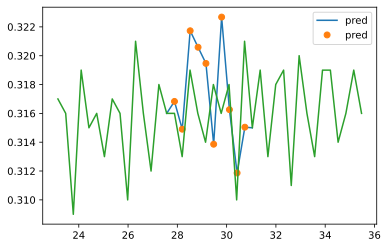

In [314]:
%config InlineBackend.figure_format = 'svg'

x = np.cumsum(final_pred)[start_hole-1:start_hole+n_forecast]
x = np.append(x,np.cumsum(true_vals)[start_hole+n_forecast])

plt.plot(x,final_pred[start_hole-1:start_hole+n_forecast+1], label='pred')
plt.plot(np.cumsum(final_pred)[start_hole:start_hole+n_forecast],final_pred[start_hole:start_hole+n_forecast],'o', label='pred')
plt.plot(np.cumsum(true_vals)[start_hole-15:start_hole+n_forecast+15],true_vals[start_hole-15:start_hole+n_forecast+15])
plt.legend()

In [281]:
final_pred[start_hole+n_forecast]
true_vals[start_hole+n_forecast]

0.315

0.315

In [34]:
print(type('hello'))
a = 'hello'
print(type(a))

<class 'str'>
<class 'str'>


In [27]:
n = 10
hole = str(n)

hole + 'hello'
hole + 'htw'
hole + 'ERR_LF'

hole + 'err_VLF'

'hello' + 'hello'

'10hello'

'10htw'

'10ERR_LF'

'10err_VLF'

'hellohello'

In [36]:
res_df = pd.read_csv('/Users/2924467/Documents/PhD-main/Code/Physionet/x002_POLAR.csv',sep=",")
idx = res_df.loc[res_df['[Params]']=='[HRData]'].index[-1]
idx+=1

physionet = res_df.iloc[idx:-1].astype(int).values
physionet = (physionet.reshape(-1))/1000


In [37]:
time = np.cumsum(physionet)
time

array([8.110000e-01, 1.622000e+00, 2.723000e+00, ..., 2.251454e+03,
       2.251826e+03, 2.252201e+03])

In [20]:
time

array([6.130000e-01, 1.217000e+00, 1.827000e+00, ..., 3.308786e+03,
       3.309365e+03, 3.309947e+03])

In [34]:
import wfdb as wf
file = '/Users/2924467/Documents/PhD-main/Code/Physionet/x001'

atr = wf.rdann(file,'atr')
aux = wf.rdann(file,'aux')

samples = atr.sample
samples

aux.sample

samples[-100:]


array([    66,    210,    354, ..., 574750, 574908, 575069])

array([  9730, 184603, 187953, 364598, 480719])

array([561348, 561464, 561580, 561694, 561809, 561926, 562045, 562164,
       562282, 562400, 562521, 562643, 562766, 562886, 563008, 563133,
       563259, 563386, 563512, 563636, 563764, 563893, 564022, 564149,
       564277, 564406, 564538, 564668, 564798, 564929, 565061, 565195,
       565325, 565458, 565593, 565732, 565871, 566006, 566136, 566267,
       566400, 566535, 566670, 566804, 566940, 567073, 567208, 567347,
       567486, 567623, 567762, 567902, 568038, 568178, 568320, 568454,
       568594, 568739, 568877, 569017, 569159, 569303, 569445, 569591,
       569741, 569888, 570031, 570182, 570330, 570474, 570617, 570767,
       570913, 571057, 571200, 571349, 571495, 571641, 571791, 571939,
       572092, 572250, 572411, 572575, 572731, 572884, 573037, 573184,
       573333, 573484, 573635, 573793, 573952, 574106, 574263, 574424,
       574589, 574750, 574908, 575069])

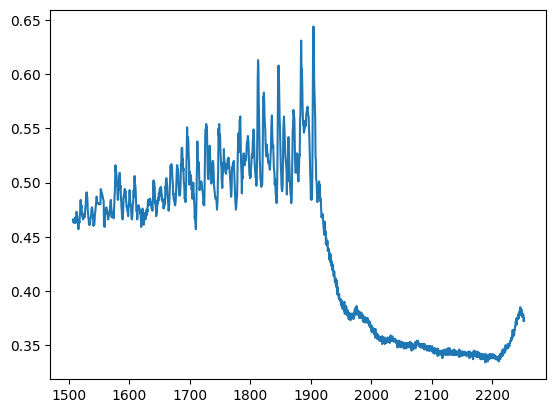

In [43]:
a = np.cumsum(physionet)
plt.plot(a[3000:],physionet[3000:])

198

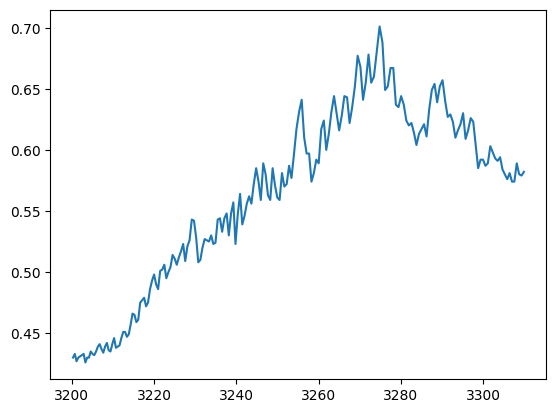

In [33]:
a = np.cumsum(physionet)
b = np.where((a>3200))

len(a[b])

#physionet[b]
#plt.plot(a[b],physionet[b])
plt.plot(a[b],physionet[b])

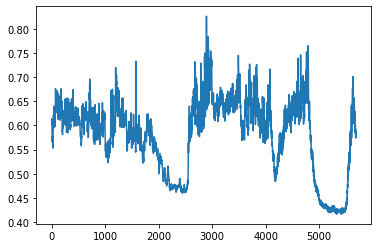

In [116]:
plt.plot(physionet)

In [3]:
file = '/Users/2924467/Documents/PhD-main/Code/Physionet/x001_FAROS.edf'


In [2]:
import pyedflib

In [4]:
f = pyedflib.EdfReader(file)

In [38]:
f.getHeader()


{'technician': '',
 'recording_additional': '',
 'patientname': '',
 'patient_additional': '',
 'patientcode': '',
 'equipment': '',
 'admincode': '',
 'gender': '',
 'startdate': datetime.datetime(2001, 1, 1, 0, 0),
 'birthdate': ''}

In [32]:
sum(physionet)

3309947

In [43]:
sum(samples)

1227603

In [ ]:
6